# Основные метрики качества классификации


 Существует множество различных числовых характеристик, позволяющих измерить качество бинарного классификатора. В случае двух классов возможны всего 4 исхода при классификации данного объекта. Их удобно отображать с помощью матрицы ошибок (confusion matrix).Это таблица с двумя строками и двумя столбцами, в ячейках которой указаны следующие значения:
- $TP$ = число верно классифицированных положительных примеров
- $FP$ = число отрицательных примеров, классифицированных положительно (ошибки первого рода)
- $TN$ = число верно классифицированных отрицательных примеров
- $FN$ = число положительных примеров, классифицированных отрицательно (ошибки второго рода)

Получить такую таблицу можно с помощью функции sklearn.metrics.confusion_matrix, передав ей на вход истинные и предсказанные классификатором метки.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
get_ipython().run_line_magic('pylab', 'inline')
import numpy as np
import seaborn as sns
from sklearn import metrics

true_labels = np.array([0, 1, 0, 0, 1, 1, 1, 1])
predicted_labels = np.array([0, 1, 1, 0, 0, 1, 0, 0])

M = metrics.confusion_matrix(true_labels, predicted_labels)
M

Populating the interactive namespace from numpy and matplotlib


array([[2, 1],
       [3, 2]])

### Многоклассовая классификация
В случае, когда число классов больше двух, матрица ошибок определяется аналогичным образом: на пересечении $i$-ой строки и $j$-го столбца стоит число примеров $i$-го класса, отнесённых классификатором к классу $j$. 


In [ ]:
true_labels = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
predicted_labels = np.array([0, 2, 0, 2, 1, 0, 0, 1, 2])

M = metrics.confusion_matrix(true_labels, predicted_labels)
M

array([[2, 0, 1],
       [0, 2, 1],
       [2, 0, 1]])

#  One vs. All
 Многоклассовая классификация может быть сведена к бинарной различными способами. Одним из них является подход One vs. All. Его суть в следующем: для каждого класса $i \in \{1, \dots, k\}$ обучим бинарный классификатор $a_i(x) = \mbox{sign}f_i(x)$ на исходной выборке с изменёнными метками (объекты $i$-го класса получают метку 1, все оставшиеся объекты - метку 0), то есть мы учим $a_i$ отличать $i$-ый класс от всех остальных. После чего итоговый классификатор строится как $a(x) = \mbox{argmax}_{i \in \{1, \dots, k\}} f_i(x)$, то есть он выдаёт класс с наибольшей оценкой $f_i(x)$. 


In [ ]:
from sklearn.datasets import load_iris
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

iris = load_iris()
X, y = iris.data, iris.target
# Fitting One vs. All version of linear SVM
onevsall = OneVsRestClassifier(LinearSVC()).fit(X, y) 
metrics.accuracy_score(y, onevsall.predict(X))

0.9666666666666667

### Характеристики бинарного классификатора
Основываясь на данной таблице, можно ввести несколько величин, характеризующих бинарный классификатор:
# $$recall = TPR = \frac{TP}{TP + FN},\quad 
SPC = \frac{TN}{TN + FP},\quad 
precision = PPV = \frac{TP}{TP + FP},\quad FRP = 1 - SPC,$$

# $$ACC = \frac{TP + TN}{TP + TN + FP + FN},\quad F1 = 2\frac{PPV\cdot TRP}{PPV + TPR}.$$

Полнота $TPR$ (True positive rate, recall, sensitivity) - доля верно классифицированных положительных примеров среди всех положительных примеров.
 
Специфичность $SPC$ (Specificity, true negative rate) - доля верно классифицированных отрицательных примеров среди всех отрицательных примеров.

Точность $PPV$ (Positive predictive value, precision) - доля верно классифицированных положительных примеров среди всех примеров, классифицированных положительно.

$FPR$ (False positive rate) - доля ошибочно классифицированных отрицательных примеров среди всех отрицательных примеров.

$ACC$ (Accuracy) - доля верно классифицированных примеров среди всех примеров. Основная характеристика качества классификации.

$F1$ (F1-measure) - среднее гармоническое точности и полноты. Позволяет учесть обе характеристики одновременно.


In [ ]:
PPV = metrics.precision_score(true_labels, predicted_labels)
TPR = metrics.recall_score(true_labels, predicted_labels)
F1 = metrics.f1_score(true_labels, predicted_labels)
ACC = metrics.accuracy_score(true_labels, predicted_labels)
PPV, TPR, F1, ACC

(0.6666666666666666, 0.4, 0.5, 0.5)

# ROC-кривая и AUC

Большинство бинарных классификаторов имеют вид $a(x) = \mbox{sign}(f(x, w) - w_0)$, где $w, w_0$ - параметры алгоритма. То есть сначала строится разделяющая поверхность $f(x, w) = w_0$, после чего объекты, находяющиеся по одну сторону от неё классифицируются положительно, по другую - отрицательно. 

# ROC-кривая (Receiver Operating Characteristic)
 - это графическая характеристика качества бинарного классификатора, выражающая зависимость TPR от FPR при варьировании порога решающего правила. Она наглядно представляет, каким будет качество классификации при различных значениях $w_0$ и фиксированном значении $w$. 

ROC-кривая проходит через точки (0, 0) и (1, 1) и монотонно не убывает. Чем ближе кривая внутри квадрата $[0, 1]\times[0, 1]$ к левому верхнему углу, тем лучше. Идеальный вариант - кривая, проходящая через три точки: (0, 0), (1, 1) и (0, 1). Диагональ данного квадрата соответствует случайному гаданию. 

На практике ROC-кривую всегда оценивают по независомой тестовой выборке, для того чтобы избежать переобучения.

# Площадь под ROC-кривой AUC (Area Under Curve)
 является количественной характеристикой качества классификации, не зависящей от соотношения цен ошибок. Чем больше значение AUC, тем «лучше» модель классификации. 


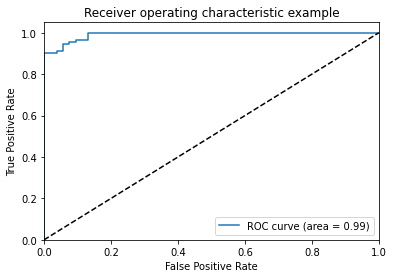

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
cancer.data, cancer.target, stratify=cancer.target, random_state=42)
C = 0.01 # Regularization parameter of the error term

lin_svm = LinearSVC(C=C, dual=False).fit(X_train, y_train)
y_score = lin_svm.decision_function(X_test)

# Compute ROC curve and ROC area
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



In [ ]:
roc_auc

0.9914046121593292

In [ ]:
[1,2,3.....10]